# Three Approaches to Squid Game Bridge Problem
## Curtis Peterson

This notebook presents three different solutions to a problem related to the Netflix show Squid Game. In the show, contestants are made to cross a bridge made up of two rows of 18 glass panels suspended over a pit of death. One of the panels in each of the 18 pairs is rigged to break when stepped on. Therefore, at every stage the contestents have a 50% chance of falling to their death. The 16 contestants are made to attempt crossing the bridge one by one, with their goal being not dying. There are several blog and forum posts online that approach this problem from a mathematical standpoint.

I thought this problem was particularly interesting because there are several different ways to approach it. In this notebook I go through three different ways to model the situation. Namely, I walk through simulating the game, deriving a recursive function with the survival probability of a particular player as an output, and model the game in terms of a [binomial random variable](https://en.wikipedia.org/wiki/Binomial_distribution), which is a well known random process. The specific goal of this notebook is obtaining the survival probability of each contestant in 3 different ways, and not answer any specific scenario-based questions about the game.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

## The Problem
A schematic of the problem is shown below. Each box represents a galss panel, and a red x denotes the panel in each pair that is rigged to break (this information is unknown to the contestants initially). A particular contestant can learn which panels are safe from previous contestants in two ways. Either a contestant will fall at a particular stage and the panel will no longer be there, or a contestant will successfully guess at that stage and subsequent contestants can retrace their steps. I'm going to assume that all of the contestants are paying attention and won't make mistakes on stages where they have knowledge. I'm also going to ignore the time limit and assume that one person is guessing at any given time. In this scenario, the important aspects of the game are that will help us model it mathematically are:

- Each time a contestant jumps to an unknown stage, the probability that they are correct is $1/2$
- The farthest stage that the contestants have knowledge of advances by at least 1 for every contestant (if they guess incorrectly on the first unknown stage)
- Once a player finishes, all players afterward will finish

![Cat](bridge_schematic.png)


## Simulation
I am going to simulate the game by brute force. In the simulation, contestants will advance one-by-one across the bridge until there are no contestants left or a contestant reaches the finish. This process will be repeated in a large number of trials so that I can obtain estimates for the probability of the $l^{th}$ contestant to reach the $k^{th}$ stage. Each jump is represented by a [Bernoulli random variable](https://en.wikipedia.org/wiki/Bernoulli_distribution) with parameter $p=1/2$. The simulation is defined in the code cell below.

In [2]:
n_trials = 1000000
n_contestants = 16
n_stages = 18
final_stage = np.zeros((n_contestants,n_trials))


for i in range(n_trials):
    p = 0
    for m in range(n_contestants):
        for n in range(p,n_stages):
            jump = np.random.randint(2)
            if jump == 0:
                p = n+1
                final_stage[m,i] = n
                final_stage[m+1:,i] = p
                break
            elif (n == n_stages - 1) and (jump == 1):
                final_stage[m:,i] = n+1
                p = n_stages
                break


Let's print out the results of the first 15 simulations. In the array below the $i^{th}$ row represents the $i^{th}$ contestant, and the $j^{th}$ column represents the $j^{th}$ simulation. The number in each spot is the final stage reached by that contestant on in that particular simulation.

In [3]:
print(final_stage[:,:14])

[[ 2.  2.  0.  0.  0.  2.  2.  3.  0.  3.  1.  0.  0.  0.]
 [ 5.  3.  3.  1.  2.  3.  7.  7.  2.  5.  4.  1.  2.  3.]
 [ 7.  7.  5.  2.  3.  4. 11.  9.  3.  6.  6.  2.  3.  4.]
 [ 8.  8.  7.  6.  6.  9. 14. 11.  4.  8. 10.  6.  5.  5.]
 [ 9.  9.  8.  8.  9. 10. 15. 12.  5.  9. 11.  8.  9.  6.]
 [10. 10. 13. 11. 12. 11. 18. 13.  7. 13. 13. 12. 10.  7.]
 [11. 12. 14. 13. 14. 12. 18. 14.  8. 16. 14. 13. 13.  9.]
 [14. 15. 18. 15. 15. 13. 18. 16. 15. 18. 15. 18. 14. 10.]
 [16. 16. 18. 17. 16. 15. 18. 17. 16. 18. 16. 18. 15. 11.]
 [17. 18. 18. 18. 17. 18. 18. 18. 17. 18. 17. 18. 18. 12.]
 [18. 18. 18. 18. 18. 18. 18. 18. 18. 18. 18. 18. 18. 16.]
 [18. 18. 18. 18. 18. 18. 18. 18. 18. 18. 18. 18. 18. 18.]
 [18. 18. 18. 18. 18. 18. 18. 18. 18. 18. 18. 18. 18. 18.]
 [18. 18. 18. 18. 18. 18. 18. 18. 18. 18. 18. 18. 18. 18.]
 [18. 18. 18. 18. 18. 18. 18. 18. 18. 18. 18. 18. 18. 18.]
 [18. 18. 18. 18. 18. 18. 18. 18. 18. 18. 18. 18. 18. 18.]]


As one might expect, early contestants do not fair well, but the last few contestants consistantly reach the end. There is a large variation in both which contestant is the first to reach safety and how far a certain contestant makes it. In order to say much more than this, we need to find a better way to visualize the data.
<br>
<br>
The function below plots a histograms of the furthest stage reached across all simulations (starting with contestant 0) for a list of specified contestants. When a contestant reaches stage 19 it means that they and everyone after them reached safety.

In [4]:
def sim_results_hist(contestants):
    
    plt.rc('xtick', labelsize=14)
    plt.rc('ytick', labelsize=14)
    plt.rc('axes', labelsize=14)
    
    for contestant in contestants:
        plt.hist(final_stage[contestant,:], bins=np.arange(20), density=True, histtype='step', linewidth=4)
    fig = plt.gcf()
    fig.set_size_inches(9, 6.5)
    plt.xticks(np.arange(20))
    plt.ylabel('probability')
    plt.xlabel('stage reached')
    plt.legend(contestants, loc='upper left')
    plt.show()

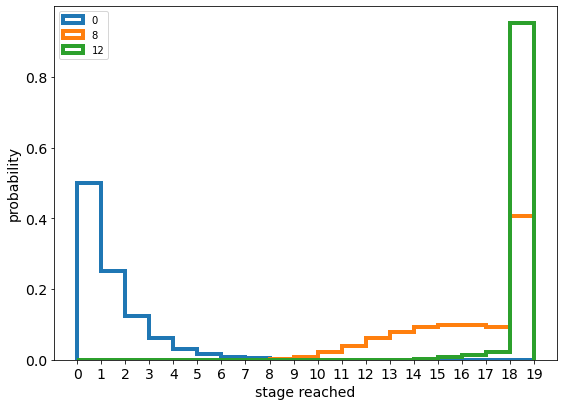

In [5]:
sim_results_hist([0,8,12])

We can also use our simulated trajectories to derive other information about the game. For example, we might ask what proportion of the contestants we expect to survive.

In [6]:
np.round(np.sum(final_stage[:,:] == n_stages)/(n_trials),5)

7.00053

## Recursive Function
The simulations conducted above give a lot of information about the game. However, they have to be run several times to get accurate results and can only provide estimated probabilities. To calculate exact probabilities, we need to find a way to write out the problem formally. A few key aspects of the problem are:
- The probability of a contestant guessing correctly $i$ times is $\frac{1}{2^{i}}$
- The probability of a contestant reaching a particular stage depends on both the stage reached by the previous contestant and the distance between the last stage reached and the particular stage
- All possible outcomes of the previous contestant need to be marginalized over
<br>
<br>
The output of the recursive function will be the probability that a contestant labelled $l$ successfully reached stage $k$, denoted $S_{l}^{k}$. The base cases for the function are $S_{l}^{0}$, representing the probability of failing at the first stage, and $S_{1}^{k}$, representing the probability of the first contestant reaching stage $k$. The first base case is

![Cat](base_case_1.png)

and the second base case is

![Cat](base_case_2.png).

For a general case, $S_{l}^{k}$, the probability of contestant $l$ sucessfully reaching stage $k$ will depend on the probability of contestant $l-1$ successfully reaching stages $k-1, k-2, ... ,0$ and the number of correct guesses required in each of those scenarios as

![Cat](formula_1.png)

where the subtraction in each term is necessary because $S_{l}^{k}$ represents the probability of contestant $l$ reaching stage $k$, including the subset of scenarios where they continue to guess correctly past stage $k$. In other words, the subtraction in each term avoids multiple counting. Most of the recursive calls in the general case above are repeated. After rearranging,

![Cat](formula_2.png)

This will be the recursive function used to calculate probabilities, and is defined in the cell below.

In [7]:
def recursive_prob(k,l):
    if l > 1 and k > 0:
        prob = 1/2**(k-1)*recursive_prob(0,l-1) + np.sum([1/2**i*recursive_prob(k-i,l-1) for i in range(1,k)])
        return prob
    elif k == 0:
        return 1
    elif l == 1:
        return 1/2**k

The function is written in a general way, and is not specific to a game with 18 stages.

In [8]:
recursive_prob(22,14)

0.8568606376647949

With the recursive function in hand, we can easily answer a number of questions. For example, the cell below calculates each of 16 contestant's probability of surviving the game.

In [9]:
survival_prob = []
for n in range(1,17):
    survival_prob.append(recursive_prob(18,n))


In [10]:
print(survival_prob)

[3.814697265625e-06, 7.2479248046875e-05, 0.0006561279296875, 0.0037689208984375, 0.01544189453125, 0.048126220703125, 0.1189422607421875, 0.2403411865234375, 0.40726470947265625, 0.5927352905273438, 0.7596588134765625, 0.8810577392578125, 0.951873779296875, 0.98455810546875, 0.9962310791015625, 0.9993438720703125]


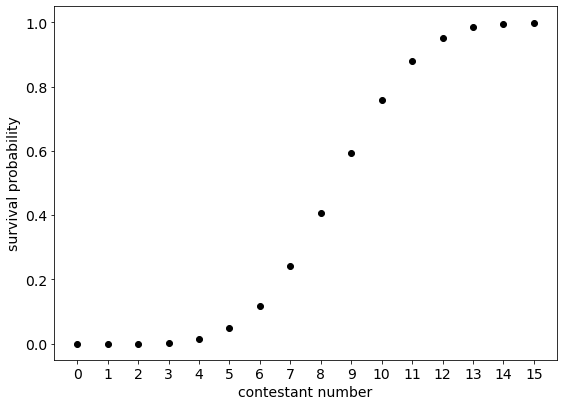

In [11]:
plt.scatter(np.arange(16), survival_prob, c='k')
fig = plt.gcf()
fig.set_size_inches(9, 6.5)
plt.xlabel('contestant number')
plt.ylabel('survival probability')
plt.xticks(np.arange(16))
plt.show()

We can also check if the recursive function is consistent with the simulations. Above, we calculated that on average around 7 contestants survived in the simulations.

In [12]:
print('Expected number of surviving contestants: ' + str(np.mean(survival_prob)*16))

Expected number of surviving contestants: 7.0000762939453125


The mean calculated survival rate is in very good agreement with the simulations.

## Binomial Random Variable
The simplest solution to this problem (and a very good strategy in general) is to make an analogy to a well-known random process. Doing this requires deciding which aspects of the problem are important, reframing those details in an abstract way, and forming an analogy between those important aspects and a more well-known problem. In this specific problem, we can describe the outcome of the game only in terms of the number of incorrect guesses (failures). Furthermore, we know that the probability of failure once any player reaches an unknown stage is 0.5. This suggests that we reframe the problem as a series of Bernoulli random variables with parameter $p=0.5$. This means that we expect the number of failures to be modeled by a binomial random variable with parameters $p=0.5$ and $n=18$. The survival probability of contestant $l$ (I'm choosing that $l$ starts at 1 here) is therefore the probability that there were up to $l-1$ failures, i.e. the CDF of a binomial random variable with parameters $p=0.5$ and $n=18$ evaluated at $l-1$.


In [13]:
from scipy.stats import binom

In [14]:
failures = np.arange(16)
survival_prob_binom = binom(18,0.5).cdf(failures)

In [15]:
print(survival_prob_binom - survival_prob)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


The results from the binomial distribution and the recursive function match exactly.